# Text classification and hyperparameter optimization

In [1]:
import numpy as np
import pandas as pd
import altair as alt
alt.renderers.enable('mimetype')
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC

<br><br>

## Exercise 1: Introducing the dataset and EDA <a name="1"></a>
<hr>

Let's develop our own SMS spam classification system using Kaggle's [SMS Spam Collection Dataset](https://www.kaggle.com/uciml/sms-spam-collection-dataset). The prediction problem here is predicting whether a given text message is spam or not spam.  

Download the CSV and save it as `spam.csv` locally in this lab folder. 

> **Some text messages contain offensive language. Unfortunately, it's the reality of such platforms 😔. If you are sensitive to such language try not to read the raw messages.** 


The starter code below reads the CSV assuming that it's present in the current directory and renames the columns of the CSV.

In [2]:
sms_df = pd.read_csv("spam.csv", encoding="latin-1")
sms_df = sms_df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
sms_df = sms_df.rename(columns={"v1": "target", "v2": "sms"})

In [3]:
sms_df.head()

,target,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### 1.1 Data splitting 
rubric={accuracy:1}

**Your tasks:**

1. Split `sms_df` into train (80%) and test splits (20%) with `random_state=123`. 

In [4]:
train, test = train_test_split(sms_df, test_size=0.2, random_state=123)
print(f"The dimension of train data is {train.shape}.\nThe dimension of test data is {test.shape}")

The dimension of train data is (4457, 2).
The dimension of test data is (1115, 2)


<br><br>

### 1.2 Simple EDA 
rubric={accuracy:3}

Note that in case of text data the usual EDA is not applicable. In this exercise, we will carry out some simple EDA to get a sense of the data.

**Your tasks:**

1. What's the label distribution in the target column? 
2. What's the average length (number of characters) of text messages? Show the shortest and longest text messages. 

> You can assume length in terms of number of characters. 

> If there are multiple messages with shortest or longest length, show the longest and shortest messages of your choice. 

In [5]:
label_dist = train['target'].value_counts()
label_dist

ham     3843
spam     614
Name: target, dtype: int64

In [6]:
avg_length = train["sms"].apply(len).mean()
avg_length

80.28427193179269

In [7]:
train["length"] = train["sms"].apply(len)
shortest_len = train["length"].min()
longest_len = train["length"].max()
print(f"Shortest message is {shortest_len} characters and the longest message is {longest_len} characters long.")

Shortest message is 2 characters and the longest message is 790 characters long.


In [8]:
train.query("length == @shortest_len")["sms"]

5357    Ok
3049    Ok
1924    Ok
4496    Ok
Name: sms, dtype: object

In [9]:
list(train.query("length == @longest_len")['sms'])[0]

"The last thing i ever wanted to do was hurt you. And i didn't think it would have. You'd laugh, be embarassed, delete the tag and keep going. But as far as i knew, it wasn't even up. The fact that you even felt like i would do it to hurt you shows you really don't know me at all. It was messy wednesday, but it wasn't bad. The problem i have with it is you HAVE the time to clean it, but you choose not to. You skype, you take pictures, you sleep, you want to go out. I don't mind a few things here and there, but when you don't make the bed, when you throw laundry on top of it, when i can't have a friend in the house because i'm embarassed that there's underwear and bras strewn on the bed, pillows on the floor, that's something else. You used to be good about at least making the bed."

<br><br>

### 1.3 Encoding 
rubric={reasoning:2}

1. How would you encode the `sms` column? Does it make sense to apply one-hot encoding on this column? Why or why not? 

_We would use bag of words (CountVectorizer) to encode this column. One-hot encoding applies to categorical column with repeated values, and we won't be able to apply it here because with a slight change in our value (adding or removing a character), our trained model might have not seen the new value, and therefore, is not able to predict our target._

<br><br>

### (Optional) 1.4 Word clouds
rubric={reasoning:1}

**Your tasks:**
1. Create two word clouds: one for text messages with `spam` target and one for text messages with `ham` target (non-spam messages). You could use [the `wordcloud` package](https://github.com/amueller/word_cloud) for this, which you will have to install in your environment.  

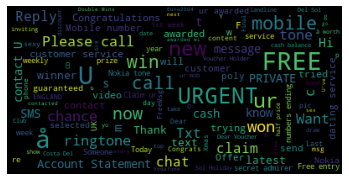

In [10]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

text_spam = train.query("target == 'spam'")["sms"].to_string()

wordcloud_spam = WordCloud(
    max_font_size=30, max_words=123, background_color="black"
).generate(text_spam)
plt.imshow(wordcloud_spam, interpolation="antialiased")
plt.axis("off")
plt.show()

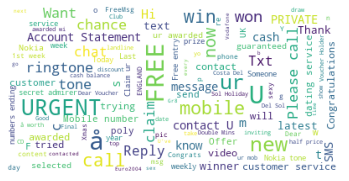

In [11]:
text_ham = train.query("target == 'spam'")["sms"].to_string()

wordcloud_ham = WordCloud(
    max_font_size=30, max_words=123, background_color="white"
).generate(text_ham)
plt.imshow(wordcloud_ham, interpolation="antialiased")
plt.axis("off")
plt.show()

<br><br><br><br>

## Exercise 2: Exploring `CountVectorizer` <a name="2"></a>
<hr>

We will be encoding the text data using [sklearn's `CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). In this exercise we will explore different options of `CountVectorizer`. 

### 2.1 `CountVectorizer` with default parameters
rubric={accuracy:3}

**Your tasks:**
1. Create `X_train`, `y_train`, `X_test`, `y_test`. 
2. Create a `CountVectorizer` with default hyperparameters and transform the training data. 
3. What's the dimensionality of the transformed data? 

> Note that unlike other transformers, you pass a `pandas.Series` object or a 1-D array to `CountVectorizer`. 

In [12]:
X_train, X_test, y_train, y_test = train_test_split(sms_df["sms"], sms_df["target"], test_size=0.2, random_state=123)

In [13]:
countvec = CountVectorizer()
sms_transformed = countvec.fit_transform(X_train)
sms_transformed

<4457x7682 sparse matrix of type '<class 'numpy.int64'>'
	with 59329 stored elements in Compressed Sparse Row format>

_Dimensianlity of the transfromed data is (4457, 7682)._

<br><br>

### 2.2 `stop_words='english'`
rubric={reasoning:2}

1. Now create a `CountVectorizer` with `stop_words='english'` and transform the training data. 
2. Did the dimensionality of the transformed data change compared to 2.1? Why or why not? 

In [14]:
countvec_eng = CountVectorizer(stop_words="english")
sms_transformed_eng = countvec_eng.fit_transform(X_train)
sms_transformed_eng

<4457x7419 sparse matrix of type '<class 'numpy.int64'>'
	with 34984 stored elements in Compressed Sparse Row format>

_The dimensionality decreased. Stop words are common words used in a language that do not help with classification models. When we are setting our model to not include them, we will end up with features not including these words, and therefore, our column count decreases. See below for stop words examples._

In [15]:
countvec_eng.get_stop_words()

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'

<br><br>

### 2.3 `max_features` 
rubric={accuracy:2}

1. Now pass the following two arguments to `CountVectorizer` and transform the training data again. 
    - `max_features=1000`
    - `stop_words=english` 
2. What's the dimensionality of the encoded data? 

In [16]:
count_vec_eng_max = CountVectorizer(stop_words="english", max_features=1000)
sms_eng_max = count_vec_eng_max.fit_transform(X_train)
sms_eng_max

<4457x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 23679 stored elements in Compressed Sparse Row format>

_The column count is 1000 since we have specifically set the maximum number of features to 1000._

<br><br>

### 2.4 Visualizing the transformed data
rubric={accuracy:4}

1. Examine some features (words) created by `CountVectorizer` in 2.3. 
2. Is the feature "phone" present in the created features? 
3. Visualize the transformed data from 2.3 as a pandas dataframe by only including the columns below (assuming they are present in the vocabulary). 
    - 'free'
    - 'love'
    - 'prize'
    - 'urgent'
4. Pick a row of your choice from this dataframe, which has a non-zero value for any of the above features, and print the corresponding text message. For example, here is an example text message, which would have a non-zero value for the feature "love".  

> \EY! CALM DOWNON THEACUSATIONS.. ITXT U COS IWANA KNOW WOTU R DOIN AT THEW/END... HAVENTCN U IN AGES..RING ME IF UR UP4 NETHING SAT.LOVE J XXX.\""


In [17]:
count_vec_eng_max.get_feature_names_out()[:100]

array(['00', '000', '03', '04', '06', '0800', '08000839402',
       '08000930705', '0870', '10', '100', '1000', '10p', '11', '12',
       '12hrs', '150', '150p', '150ppm', '16', '18', '1st', '20', '200',
       '2000', '2003', '20p', '25', '250', '25p', '2day', '2lands', '2nd',
       '2nite', '30', '3030', '350', '4u', '50', '500', '5000', '750',
       '800', '8007', '86688', '87066', '87077', '8th', '900', 'able',
       'abt', 'ac', 'accept', 'account', 'actually', 'address', 'admirer',
       'aft', 'afternoon', 'age', 'ago', 'ah', 'aight', 'al', 'alex',
       'alright', 'amp', 'angry', 'ans', 'answer', 'anytime', 'apply',
       'appreciate', 'ard', 'area', 'asap', 'ask', 'askd', 'asked',
       'asking', 'ass', 'attempt', 'auction', 'available', 'await',
       'awaiting', 'awake', 'award', 'awarded', 'away', 'awesome', 'b4',
       'babe', 'baby', 'bad', 'balance', 'bank', 'bath', 'bathe', 'bcoz'],
      dtype=object)

In [18]:
"phone" in count_vec_eng_max.get_feature_names_out()

True

In [19]:
pd.DataFrame(sms_eng_max.toarray(), columns=list(count_vec_eng_max.get_feature_names_out()))[["free", "love", "prize", "urgent"]]

,free,love,prize,urgent
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,1,1
4,0,0,0,0
...,...,...,...,...
4452,0,0,0,0
4453,1,0,0,0
4454,0,0,0,0
4455,0,0,0,0


In [20]:
row_3 = pd.DataFrame(sms_eng_max.toarray(), columns=list(count_vec_eng_max.get_feature_names_out())).iloc[3]
" ".join(row_3[row_3 == 1].index.tolist()).upper()

'03 06 10 150PPM 2000 2ND ASAP ATTEMPT BONUS BOX CALLER MOBILE NUMBER PRIZE REACH URGENT WON'

<br><br>

### 2.5 Discussion
rubric={reasoning:5}

1. Are we likely to overfit or underfit with less number of `max_features`? Briefly discuss. 
2. Transform the `ex_msg` given below using the `CountVectorizer` from 2.3. How many non-zero elements are there in the bag-of-words representation of this message? 
3. Comment on how unknown words are handled by `CountVectorizer`. For example, the word "MDS" is unlikely to be present in the vocabulary built by the `CountVectorizer` on this dataset. How is it handled during transformation? 

_1. With lower features we are likely to underfit, as opposed to including all features where we are likely to overfit. For lower number of features we do not have enough word features in order to use for prediction, and will therefore, have bias towards predicting the same thing (average value) over and over again. In other words, we will be ignoring a lot of words in our test and deployment data if we only use selective few from our train data._

In [21]:
ex_msg = "I am learning many new topics in MDS."

In [22]:
count_vec_eng_max.transform(pd.Series(ex_msg))

<1x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 1 stored elements in Compressed Sparse Row format>

_2. From the above we can see that we have only one non-zero value stored in our sparse matrix._

_3. Unknown words are ignored when we transform our data using CountVectorizer simply because no corresponding column would exist from the fit stage in order to store the count of the new word._

<br><br><br><br>

## Exercise 3: Model building <a name="3"></a>
<hr>

## 3.1 `DummyClassifier`
rubric={reasoning:2}

Now it's time to build models. Let's start with a baseline model. 

**Your tasks:**
1. Report mean cross-validation scores of  `DummyClassifier`  with default hyperparameters for this problem.  
2. Briefly comment on the scores. 

In [23]:
cross_validate(DummyClassifier(), X_train, y_train)["test_score"].mean()

0.862239233390205

_Mean CV score for dummy classifier is **0.86** meaning that if we just go with the most common target value, we will get a 86% accuracy. This is mainly due to the target values not having a balanced distribution. In other words there are a lot more ham examples than spam, and if we predicted ham as our prediction for everything, 86% of the time we would have been correct._

<br><br>

### 3.2 `SVC` with default parameters
rubric={accuracy:2}

1. Now build a pipeline for feature extraction using `CountVectorizer` with `stop_words='english'` and `SVC` with default hyperparameters.
2. Are you getting better scores with `SVC` compared to `DummyClassifier`?

In [24]:
pipe = make_pipeline(CountVectorizer(stop_words="english"), SVC())

cross_validate(pipe, X_train, y_train)["test_score"].mean()

0.9771126813727712

_The mean cross validation score is **0.977** which is a big improvement over the dummy classifier CV score._

<br><br><br><br>

## Exercise 4: Hyperparameter optimization <a name="4"></a>
<hr>

So far we have been writing loops to try a bunch of different hyperparameter values and pick the one with lowest cross-validation error. This operation is so common that `scikit-learn` has some [built-in methods](https://scikit-learn.org/stable/modules/grid_search.html) to do it for you. In this exercise, we will explore two such methods:

1. [`sklearn.model_selection.GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) 
2. [`sklearn.model_selection.RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

### 4.1 Optimizing `C` for SVM RBF
rubric={accuracy:4,reasoning:2}

1. Carry out hyperparameter search over `C` by sweeping the hyperparameter through the values $10^{-3}, \ldots, 10^{-1}, 1, \ldots, 10^{3}$ using [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and 10-fold cross-validation. (The `param_grid` is given in the starter code below.) 
2. Plot training and cross-validation curves (mean train and mean cross-validation scores for different values of `C` from the `param_grid`) with `C` on the x-axis and scores on the y-axis. You can use the plotting library of your choice. 
3. What are the best hyperparameter value and the corresponding best cross-validation score found by your search? Compare the score with the score you got in exercise 3.2 (i.e., `SVC` with default parameters). 

A few tips about `GridSearchCV`: 

- The starter code below defines the parameter grid for `C` which you can pass to your `GridSearchCV`. Note the syntax `svc__C`. We have two steps in our pipeline and we can access the parameters of these steps using `__` to go deeper. So `svc__C` means `C` of `svc` step of the pipeline. 
- Setting `n_jobs=-1` should speed things up (if you have a multi-core processor).
- Similar to `cross_validate`, you can pass `return_train_score=True` to your `GridSearchCV` object.
- By default, after carrying out the search, `GridSearchCV` also refits a model with the entire training set with the best hyperparameter values. 

In [25]:
param_grid = {"svc__C": 10.0 ** np.arange(-3, 4)}

In [26]:
pipe = make_pipeline(CountVectorizer(), SVC())
grid = GridSearchCV(
    pipe, param_grid=param_grid, cv=10, n_jobs=-1, return_train_score=True
)
grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid={'svc__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             return_train_score=True)

In [27]:
results = pd.DataFrame(grid.cv_results_)[["param_svc__C", "mean_test_score", "mean_train_score"]]
results

,param_svc__C,mean_test_score,mean_train_score
0,0.001,0.862240,0.862239
1,0.01,0.862240,0.862239
2,0.1,0.865380,0.866527
3,1.0,0.979803,0.995139
4,10.0,0.981823,0.999776
5,100.0,0.981599,1.000000
6,1000.0,0.981599,1.000000


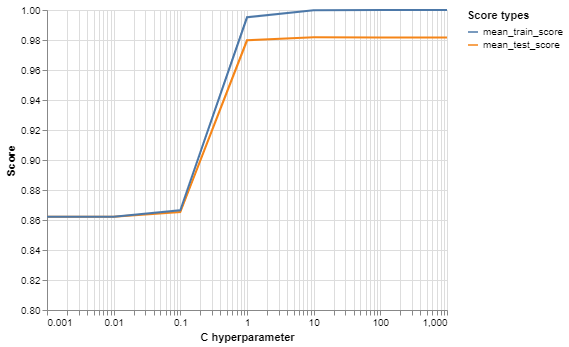

In [28]:
melted_result = results.melt(id_vars="param_svc__C")
alt.Chart(melted_result).mark_line().encode(
    x=alt.X("param_svc__C", scale=alt.Scale(type="log"), title="C hyperparameter"),
    y=alt.Y("value", scale=alt.Scale(domain=(0.8, 1)), title="Score"),
    color=alt.Color("variable", sort="-color", title="Score types"),
)

In [29]:
grid.best_score_

0.9818229455333298

In [30]:
grid.best_params_

{'svc__C': 10.0}

The best validation score after doing grid search is **0.982** which is a 0.5% improvement over the default SVC parameters.

<br><br>

### 4.2 Jointly optimizing `C` and `gamma`
rubric={accuracy:4,reasoning:2}

Let's optimize `C` hyperparameter along with `gamma`. 

**Your tasks:**

1. Expand your search to cover the `gamma` hyperparameter in addition to `C`, sweeping the hyperparameter through values $10^{-3}, 10^{-2}, \ldots, 10^{3}$. Use the same `C` values from Exercise 4.1. 
2. Did you get the same best `C` value in this search that you got when optimizing `C` only in 4.1? Briefly discuss. 

In [31]:
param_grid = {
    "svc__C": 10.0 ** np.arange(-3,4),
    "svc__gamma": 10.0 ** np.arange(-3,4),
}

In [32]:
pipe_gamma_C = make_pipeline(CountVectorizer(), SVC())
grid_gamma_C = GridSearchCV(
    pipe_gamma_C,
    param_grid,
    n_jobs=-1,
    return_train_score=True,
)
grid_gamma_C.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid={'svc__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'svc__gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             return_train_score=True)

In [33]:
opt_results = pd.DataFrame(grid_gamma_C.cv_results_)[
    ["param_svc__gamma", "param_svc__C", "mean_test_score"]
]
opt_results.head()

,param_svc__gamma,param_svc__C,mean_test_score
0,0.001,0.001,0.862239
1,0.01,0.001,0.862239
2,0.1,0.001,0.862239
3,1.0,0.001,0.862239
4,10.0,0.001,0.862239


In [34]:
grid_gamma_C.best_params_

{'svc__C': 100.0, 'svc__gamma': 0.01}

In [35]:
grid_gamma_C.best_score_

0.9840671286859628

_While optimizing both gamma and C I got a different C value (100) which in combination with the new gamma of 0.01 slightly improved my score to **0.984**. This does not say that this C score gives me the best score if applied alone. What it means is that in combination with gamma=0.01 this C value gives the best score in my grid search._

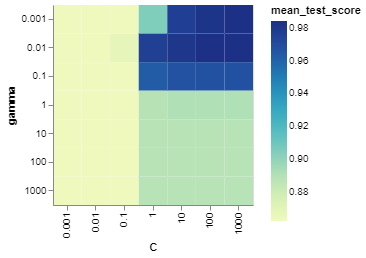

In [36]:
alt.Chart(opt_results).mark_rect().encode(
    x=alt.X("param_svc__C:O", title="C"),
    y=alt.Y("param_svc__gamma:O", title="gamma"),
    color="mean_test_score:Q",
).properties(
    width=200,
    height=200
)

<br><br>

### 4.3 Optimizing `C` and `gamma` of SVM RBF and `binary` and `max_features` of `CountVectorizer` jointly with `RandomizedSearchCV`
rubric={accuracy:4,reasoning:2}

Similar to estimators, transformers also have hyperparameters. In this exercise, you'll jointly optimize hyperparameters of `SVC` as well as `CountVectorizer` using 
`RandomizedSearchCV`, which, as its name implies, tries random hyperparameter configurations instead of performing an exhaustive grid search. 

**Your tasks:**

1. Jointly optimize `C` and `gamma` hyperparameters of SVC RBF, and `binary` and `max_features` hyperparameters of `CountVectorizer` using [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). For the  search, use an object named `random_search` shown below. For all hyperparameters use reasonable ranges of values of your choice. 

2. Name a situation in which random search would be strongly preferable over a grid search, and briefly explain why.  

In [37]:
from scipy.stats import expon, lognorm, loguniform, randint, uniform
uniform(0.1, 1e4)

In [38]:
from scipy.stats import loguniform, randint, uniform

pipe = make_pipeline(CountVectorizer(), SVC())
param_distributions = {
    "countvectorizer__binary": [True, False],
    "countvectorizer__max_features": randint(50, 5000),
    "svc__gamma": loguniform(1e-2, 1e3),
    "svc__C": uniform(1e-1, 1e3),
}

random_search = RandomizedSearchCV(pipe, param_distributions, n_iter=100, n_jobs=-1, random_state=123)

In [39]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                              CountVectorizer()),
                                             ('svc', SVC())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'countvectorizer__binary': [True,
                                                                    False],
                                        'countvectorizer__max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000208C0419D00>,
                                        'svc__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000208C0419BB0>,
                                        'svc__gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000208BF3D2E20>},
                   random_state=123)

In [40]:
random_search.best_params_

{'countvectorizer__binary': True,
 'countvectorizer__max_features': 3345,
 'svc__C': 214.11191490834625,
 'svc__gamma': 0.03366893122619186}

In [41]:
random_search.best_score_

0.9858626121705344

_1. We see a minor improvement in score when applying random search. The best score and parameters are shown above._  
_2. One of the situations that RandomSearchCV would give us huge advantage is when we have one or two hyperparameters that are more important that others. In contrast with GridSearch we can define distributions for our hyperparameter to reflect this importance._

<br><br>

### (Optional) 4.4: More sophisticated hyperparameter tuning. 
rubric={reasoning:1} 

There are all sorts of software packages that make hyperparameter tuning with `scikit-learn` even more automated. For example:

- [hyperopt-sklearn](https://github.com/hyperopt/hyperopt-sklearn)
- [auto-sklearn](https://github.com/automl/auto-sklearn)
- [SigOptSearchCV](https://sigopt.com/docs/overview/scikit_learn)

Give one of these a try and report your thoughts. Or, if you're even more adventurous, you could try a package that isn't tied to `scikit-learn`. There are many options for you to play around with in your ample free time:

- [TPOT](https://github.com/rhiever/tpot)
- [hyperopt](https://github.com/hyperopt/hyperopt)
- [hyperband](https://github.com/zygmuntz/hyperband)
- [SMAC](http://www.cs.ubc.ca/labs/beta/Projects/SMAC/)
- [MOE](https://github.com/Yelp/MOE)
- [pybo](https://github.com/mwhoffman/pybo)
- [spearmint](https://github.com/HIPS/Spearmint)
- [BayesOpt](https://github.com/rmcantin/bayesopt)

Note: this list isn't meant to be exhaustive. 

In other news, the recently announced [Amazon SageMaker](https://aws.amazon.com/sagemaker/) is also supposed to do hyperparameter optimization for you (among many other things it does).

<br><br><br><br>

## Exercise 5: Test results <a name="5"></a>
<hr>

Now that we have done extensive hyperparameter search, it's time to assess our model. 

### 5.1 Assessing the model
rubric={reasoning:4}

**Your tasks**

1. Evaluate your final model from 4.3 on the test set. 
2. How does your test accuracy compare to your validation accuracy?  
3. Try the best model on a couple of spam and ham (non-spam) text messages from your inbox. Do you believe that this model is likely to identify spam messages in the wild with the observed accuracy? Briefly discuss. 

In [42]:
optimized_pipe = make_pipeline(
    CountVectorizer(binary=True, max_features=3345), SVC(gamma=0.03, C=214)
)

optimized_pipe.fit(X_train, y_train)
optimized_pipe.score(X_test, y_test)

0.9829596412556054

_2. The test accuracy is **0.983** which is very close to our best cross_validation score of **0.986** from the above hyperparameter optimization._

In [43]:
text = pd.Series(
    [
        "Hello, I have a profitable deal to share with you, 50% for you if you can help me close the deal. Please reply if you are interested to know more and how you can help me.",
        "𝖸𝗈𝗎 𝗐𝖾𝗋𝖾 𝗋𝖾𝖼𝖾𝗇𝗍𝗅𝗒 𝖺𝗌𝗄𝖾𝖽 𝗍𝗈 𝗍𝖺𝗄𝖾 𝖺𝗇 𝖺𝖼𝗍𝗂𝗈𝗇 𝗈𝗇 𝗒𝗈𝗎𝗋 𝖺𝖼𝖼𝗈𝗎𝗇𝗍 𝖺𝗇𝖽 𝗂𝗍 𝗅𝗈𝗈𝗄𝗌 𝗅𝗂𝗄𝖾 𝗐𝖾 𝖽𝗂𝖽𝗇'𝗍 𝗋𝖾𝖼𝖾𝗂𝗏𝖾 𝖺 𝗋𝖾𝗊𝗎𝖾𝗌𝗍𝖾𝖽 𝗋𝖾𝗌𝗉𝗈𝗇𝗌𝖾. 𝖶𝖾 𝗁𝖺𝗏𝖾 𝖿𝗈𝗎𝗇𝖽 𝗌𝗎𝗌𝗉𝗂𝖼𝗂𝗈𝗎𝗌 𝖺𝖼𝗍𝗂𝗏𝗂𝗍𝗒 𝗈𝗇 𝗍𝗁𝖾 𝖼𝗋𝖾𝖽𝗂𝗍 𝖼𝖺𝗋𝖽 𝗅𝗂𝗇𝗄𝖾𝖽 𝗍𝗈 𝗒𝗈𝗎𝗋 𝖯𝖺𝗒𝖯𝖺𝗅 𝖺𝖼𝖼𝗈𝗎𝗇𝗍. 𝖸𝗈𝗎 𝗆𝗎𝗌𝗍 𝖼𝗈𝗇𝖿𝗂𝗋𝗆 𝗒𝗈𝗎𝗋 𝗂𝖽𝖾𝗇𝗍𝗂𝗍𝗒 𝗍𝗈 𝖼𝗈𝗇𝖿𝗂𝗋𝗆 𝗍𝗁𝖺𝗍 𝗒𝗈𝗎 𝖺𝗋𝖾 𝗍𝗁𝖾 𝗈𝗐𝗇𝖾𝗋 𝗈𝖿 𝗍𝗁𝖾 𝖼𝗋𝖾𝖽𝗂𝗍 𝖼𝖺𝗋𝖽.",
    ]
)
optimized_pipe.predict(text)

array(['ham', 'ham'], dtype=object)

_3. As shown in the example above from my inbox the two spam emails have been classified as ham. This shows that the model is not able to predict well in the wild. The main reason this is happening is the very low number of sample data (less than 10_000), and a very small percentage of spam emails in the train data set. In order for this model to generalize better we will need more observations (in the order of millions) and a more balanced target distribution._

<br><br><br><br>

**PLEASE READ BEFORE YOU SUBMIT:** 

When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from "1" will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Push all your work to your GitHub lab repository. 
4. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 
5. Make sure that the plots and output are rendered properly in your submitted file. 